In [3]:
import os
import sys

cwd = os.getcwd()
folder = os.path.basename(cwd)
while folder != "beam":
    cwd = os.path.dirname(cwd)
    folder = os.path.basename(cwd)
    if len(cwd) == 0:
        print("Root directory was not found. Try inserting the path manually with 'sys.path.insert(0, absolute_path_to_root)'")
        sys.exit()
sys.path.insert(0, cwd)

import functools
import numpy as np
from system import System
import mesh
import postprocessing as postproc
import matplotlib.pyplot as plt

In [4]:
from beam_tests import test_twist

Root directory: c:\Users\jan.tomec\OneDrive - Sveučilište u Rijeci\THREAD\beam


In [5]:
system11 = test_twist.case1(8, 8)
system11.solve()
system12 = test_twist.case1(16, 8)
system12.solve()
system13 = test_twist.case1(32, 8)
system13.solve()

Hello, world!
This is a FEM program for beam analysis.
This will be a static analysis.
Time step: 1 (time 0.0 --> 1.0)
Iteration: 0 	Residual: 94888.68690175355
Iteration: 1 	Residual: 3.5003566761921814e-09
	Time step converged within 2 iterations.

	Active nodes have changed: repeat time step.

Iteration: 0 	Residual: 3.5003566761921814e-09
	Time step converged within 1 iterations.

Time step: 2 (time 1.0 --> 2.0)
Iteration: 0 	Residual: 5692.7315617725235
Iteration: 1 	Residual: 117.44440370912845
Iteration: 2 	Residual: 144.11829806486054
Iteration: 3 	Residual: 0.5986427019147115
Iteration: 4 	Residual: 0.0007342023463356689
Iteration: 5 	Residual: 4.181801919197944e-09
	Time step converged within 6 iterations.

	Active nodes have changed: repeat time step.

Iteration: 0 	Residual: 0.985577665708121
Iteration: 1 	Residual: 0.05486954443236192
Iteration: 2 	Residual: 4.773279809893401e-07
	Time step converged within 3 iterations.

	Active nodes have changed: repeat time step.

Iter

In [6]:
system14 = test_twist.case1(64, 8)
system14.solve()

Hello, world!
This is a FEM program for beam analysis.
This will be a static analysis.
Time step: 1 (time 0.0 --> 1.0)
Iteration: 0 	Residual: 759109.4952140307
Iteration: 1 	Residual: 1.2020063355857852e-07
	Time step converged within 2 iterations.

	Active nodes have changed: repeat time step.

Iteration: 0 	Residual: 1.2020063355857852e-07
	Time step converged within 1 iterations.

Time step: 2 (time 1.0 --> 2.0)
Iteration: 0 	Residual: 44997.53588402154
Iteration: 1 	Residual: 5983.0527871443865
Iteration: 2 	Residual: 1398.8421108198881
Iteration: 3 	Residual: 8.986386805436535
Iteration: 4 	Residual: 0.015762277332258542
Iteration: 5 	Residual: 1.1595947189996443e-07
	Time step converged within 6 iterations.

	Active nodes have changed: repeat time step.

Iteration: 0 	Residual: 11.342218504318963
Iteration: 1 	Residual: 0.00046494452181512834
Iteration: 2 	Residual: 1.1616340233876741e-07
	Time step converged within 3 iterations.

	Active nodes have changed: repeat time step.

I

In [10]:
system15 = test_twist.case1(8, 64)
system15.solve()

Hello, world!
This is a FEM program for beam analysis.
This will be a static analysis.
Time step: 1 (time 0.0 --> 1.0)
Iteration: 0 	Residual: 94888.68690175355
Iteration: 1 	Residual: 3.5003566761921814e-09
	Time step converged within 2 iterations.

Time step: 2 (time 1.0 --> 2.0)
Iteration: 0 	Residual: 5692.731561772523
Iteration: 1 	Residual: 11.447656640351004
Iteration: 2 	Residual: 8.935327620114729e-05
Iteration: 3 	Residual: 9.10855382442053e-09
	Time step converged within 4 iterations.

	Active nodes have changed: repeat time step.

Iteration: 0 	Residual: 0.0014393463026716375
Iteration: 1 	Residual: 0.10017681172870001
Iteration: 2 	Residual: 5.3031170607922855e-06
Iteration: 3 	Residual: 6.639501307484128e-09
	Time step converged within 4 iterations.

	Active nodes have changed: repeat time step.

Iteration: 0 	Residual: 12.167083187459726
Iteration: 1 	Residual: 0.0055973958709329905
Iteration: 2 	Residual: 2.3699768809270892e-07
	Time step converged within 3 iterations.


In [33]:
system16 = test_twist.case1(8, 3)
system16.solve()
system17 = test_twist.case1(8, 2)
system17.solve()

Hello, world!
This is a FEM program for beam analysis.
This will be a static analysis.
Time step: 1 (time 0.0 --> 1.0)
Iteration: 0 	Residual: 94888.68690175355
Iteration: 1 	Residual: 3.5003566761921814e-09
	Time step converged within 2 iterations.

	Active nodes have changed: repeat time step.

Iteration: 0 	Residual: 3.5003566761921814e-09
	Time step converged within 1 iterations.

Time step: 2 (time 1.0 --> 2.0)
Iteration: 0 	Residual: 5692.7315617725235
Iteration: 1 	Residual: 49.19566594077965
Iteration: 2 	Residual: 38.68092361724769
Iteration: 3 	Residual: 0.2543724897470524
Iteration: 4 	Residual: 0.00040812469935283817
Iteration: 5 	Residual: 3.5189915244409977e-09
	Time step converged within 6 iterations.

	Active nodes have changed: repeat time step.

Iteration: 0 	Residual: 0.0007514635623964466
Iteration: 1 	Residual: 0.050662877058085
Iteration: 2 	Residual: 4.4944336463334957e-07
	Time step converged within 3 iterations.

	Active nodes have changed: repeat time step.

I

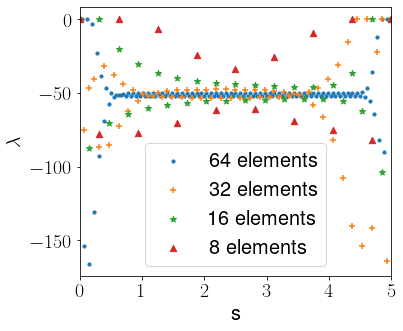

In [9]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 20
})
fig = plt.figure(figsize=(6,5), tight_layout=True)
ax = plt.axes()
f1 = system11.lagrange[-1][len(system11.lagrange[-1])//2:]
f2 = system12.lagrange[-1][len(system12.lagrange[-1])//2:]
f3 = system13.lagrange[-1][len(system13.lagrange[-1])//2:]
f4 = system14.lagrange[-1][len(system14.lagrange[-1])//2:]
x1 = np.linspace(0, 5, len(f1))
x2 = np.linspace(0, 5, len(f2))
x3 = np.linspace(0, 5, len(f3))
x4 = np.linspace(0, 5, len(f4))
ax.scatter(x4, f4, marker=".", s=40, label='64 elements')
ax.scatter(x3, f3, marker="+", s=40, label='32 elements')
ax.scatter(x2, f2, marker="*", s=40, label='16 elements')
ax.scatter(x1, f1, marker="^", s=40, label='8 elements')
ax.set_xlim((0,5))
ax.set_xlabel('s')
ax.set_ylabel('$\lambda$')
plt.legend()
plt.savefig("img2.pdf", bbox_inches='tight')

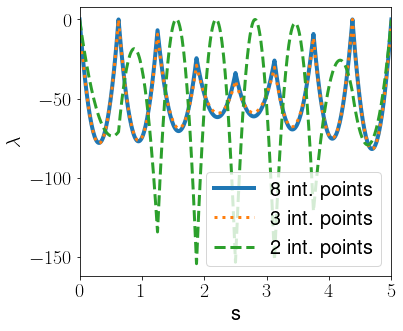

In [35]:
fig = plt.figure(figsize=(6,5), tight_layout=True)
ax = plt.axes()
f1 = system11.contact_force_function(-1)
f5 = system15.contact_force_function(-1)
f6 = system16.contact_force_function(-1)
f7 = system17.contact_force_function(-1)
ax.plot(f1[:,0], f1[:,1], '-', label='8 int. points', linewidth=4.0)
ax.plot(f6[:,0], f6[:,1], ':', label='3 int. points', linewidth=3.0)
ax.plot(f7[:,0], f7[:,1], '--', label='2 int. points', linewidth=3.0)
ax.set_xlim((0,5))
ax.set_xlabel('s')
ax.set_ylabel('$\lambda$')
plt.legend()
plt.savefig("int.pdf", bbox_inches='tight')